# Config

In [1]:
NUMBER_OF_REGIONS = 20
HIDDEN_LAYER_SIZE = (10, 20)

In [2]:
DATA_SOURCES = {'Kaggle': 0       # Kaggle, initial datasource on Kaggle, processing on Google servers
                , 'Gdrive': 1     # GDRIVE, reprocessed data sources, processing on Google servers
                , 'Local': 2      # localhost, for processing on local PC
}
DATA_SOURCE = DATA_SOURCES['Local']

LOAD_MODEL = 0

# Work with datasets

Download files from Kaggle

In [3]:
if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  #! kaggle datasets list
  ! kaggle competitions download -c novozymes-enzyme-stability-prediction
  ! mkdir novozymes_data
  ! unzip -o novozymes-enzyme-stability-prediction.zip -d novozymes_data
  ! mkdir train/
  ! mkdir test/
  ! \cp -r novozymes_data/train.csv train/train.csv
  ! \cp -r novozymes_data/train_updates_20220929.csv train/train_exclude.csv
  ! \cp -r novozymes_data/test.csv test/test.csv

In [4]:
if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import numpy as np
from math import ceil
import time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  0


In [5]:
if DATA_SOURCE == DATA_SOURCES['Local']:
  WORK_DIREKTORY = 'C:\\Novozymes\\'

  train_file = WORK_DIREKTORY + 'train.csv'
  train_excludes_file = WORK_DIREKTORY + 'train_updates_20220929.csv'
  test_file = WORK_DIREKTORY + 'test.csv'

if DATA_SOURCE == DATA_SOURCES['Gdrive']:
  from google.colab import drive
  import os
  from distutils.dir_util import copy_tree

  WORK_DIREKTORY = '/content/gdrive/MyDrive/Colab Notebooks/Novozymes/'

  train_file = WORK_DIREKTORY + 'novozymes_dataset/train.csv'
  train_excludes_file = WORK_DIREKTORY + 'novozymes_dataset/train_updates_20220929.csv'
  test_file = WORK_DIREKTORY + 'novozymes_dataset/test.csv'

  drive.mount('/content/gdrive/', force_remount=True)

if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  train_file = 'train/train.csv'
  train_excludes_file = 'train/train_exclude.csv'
  test_file = WORK_DIREKTORY + 'test/test.csv'


In [6]:
enzime_codes = []
labels = []
test_enzime_codes = []
test_labels = []

with open(train_excludes_file, 'r') as f:
  data_exclude = np.array([x.split(',') for x in f.readlines()])
data_exclude = np.array(data_exclude[data_exclude[:, 1] != ''][1:, 0], dtype=int)

with open(train_file, 'r') as f:
  #data = np.array([x.split(',') for x in f.readlines()[1:BATCH_SIZE]])
  while True:
    row = f.readline()
    if not row:
      break
    data_row = row.split(',')  
    if (data_row[0] in data_exclude) or (data_row[0] == 'seq_id') or (float(data_row[-1].replace('\n','')) <= 55):
      continue
    # print(data_row)
    try:
      if int(data_row[0])%51 == 0:
        test_labels.append(float(data_row[-1].replace('\n','')))
        test_enzime_codes.append([data_row[1], data_row[2]])
      else:
        labels.append(float(data_row[-1].replace('\n','')))
        enzime_codes.append([data_row[1], data_row[2]])
    except Exception:
      print(data_row)
      raise Exception

train_dataset = tf.data.Dataset.from_tensor_slices((np.array(enzime_codes), np.array(labels))).shuffle(len(enzime_codes))
control_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_enzime_codes), np.array(test_labels))).shuffle(len(test_enzime_codes))

C:\Users\hp\AppData\Local\Temp\ipykernel_22268\3821546586.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (data_row[0] in data_exclude) or (data_row[0] == 'seq_id') or (float(data_row[-1].replace('\n','')) <= 55):


In [ ]:
next(iter(control_dataset))

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'MPVKSDDIKSRGGDAESLITSFLEKNSDSYFTLKEISESTGIDIIELHVIITMMLWSGRIKYRDIYDHENKLRRYYAIN',
        b'7.0'], dtype=object)>,
 <tf.Tensor: shape=(), dtype=float64, numpy=79.4>)

# Research

Read and clean data

In [7]:
def res_normalized(y: np.array) -> np.array:
  return y / 150

def res_sigmoid(y: np.array) -> np.array:
  return 1 / (1 + np.exp(- (y - 50)/7.5))

def res_tanh(y: np.array) -> np.array:
  return np.tanh((y - 50)/10)

def res_arcsinh_norm(y: np.array) -> np.array:
  return np.arcsinh((y-50)/2)/10 + 0.5

def res_arcsinh(y: np.array) -> np.array:
  return np.arcsinh((y-50)/2)

In [8]:
def remove_sigmoid(y: np.array) -> np.array:
  if y == 0:
    return -1000
  return 50 - 7.5 * np.log(1/y - 1)

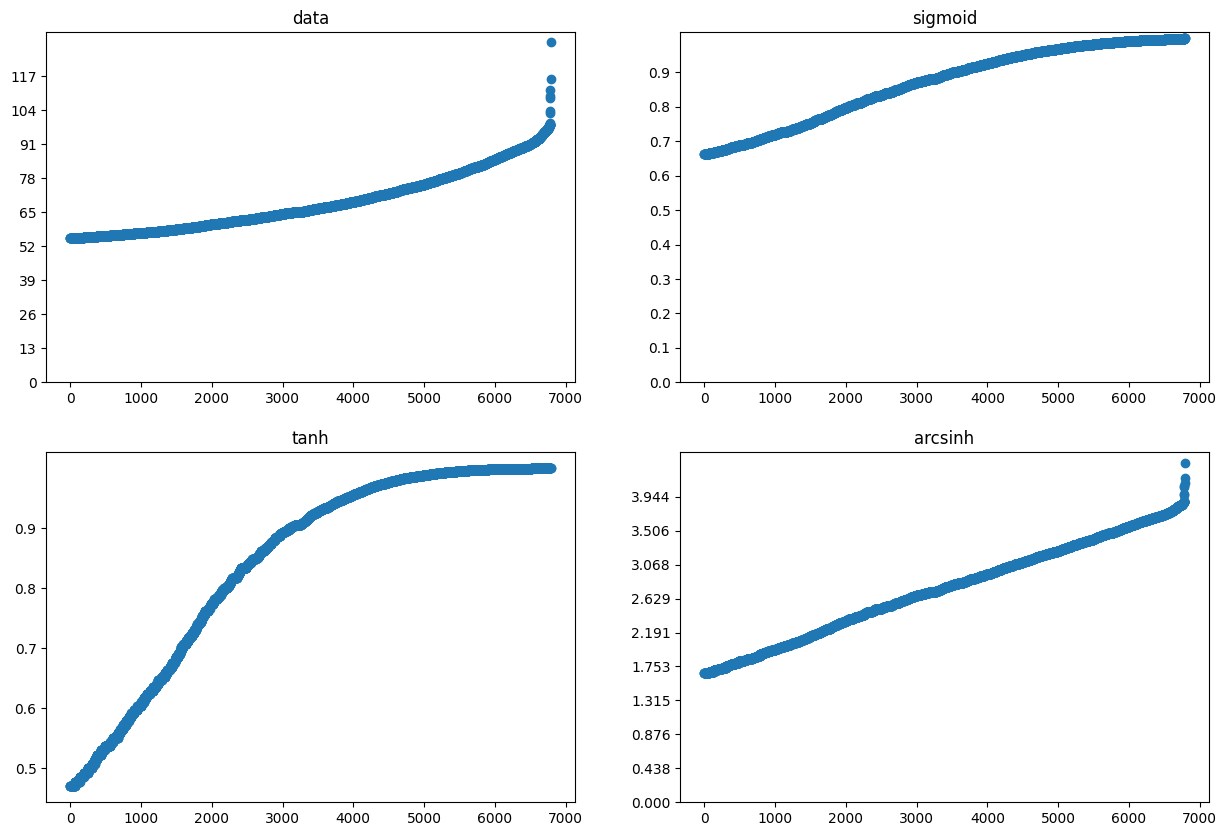

In [9]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

y_data = np.array(labels, dtype=float)

plt.subplot(2,2,1)
plt.scatter( np.arange(0,len(y_data)), np.sort(y_data))
ax[0, 0].set(yticks=np.arange(0, 10)*np.max(y_data)/10)
plt.title('data')

plt.subplot(2,2,2)
y_sigmoid = res_sigmoid(y_data) 
plt.scatter( np.arange(0,len(y_sigmoid)), np.sort(y_sigmoid))
ax[1, 0].set(yticks=np.arange(0, 10)*np.max(y_sigmoid)/10)
plt.title('sigmoid')

plt.subplot(2,2,3)
y_tanh = res_tanh(y_data) 
plt.scatter( np.arange(0,len(y_tanh)), np.sort(y_tanh))
ax[0, 1].set(yticks=np.arange(0, 10)*np.max(y_tanh)/10)
plt.title('tanh')

plt.subplot(2,2,4)
y_arcsinh = res_arcsinh(y_data) 
plt.scatter( np.arange(0,len(y_arcsinh)), np.sort(y_arcsinh))
ax[1, 1].set(yticks=np.arange(0, 10)*np.max(y_arcsinh)/10)
plt.title('arcsinh')

plt.show()

We will try to use as a labels and as result for our model **res_sigmoid(tm)** or **res_tanh(tm)** or **res_arcsinh(tm)**, cause it allows us to seek more steady solution, without some extremly low and hight cases. Shall check them all, probably.

# Convolution

In [10]:
MAX_LENGTH = 0

# Create dictionary for protein_sequence
dictionary = {}
for d in enzime_codes:
  MAX_LENGTH = max(MAX_LENGTH, len(d[0]))
  for l in d[0]:
    if l not in dictionary:
      dictionary[l] = 0
    dictionary[l] += 1

print(len(dictionary))
vocab = np.array(sorted(dictionary.items()))[:, 0]
dictionary = tuple(enumerate(tf.constant(np.array(sorted(dictionary.items()))[:, 0])))
print(vocab)
print(MAX_LENGTH)

AMINO_ACIDS_COUNT = len(dictionary)
TEMPLATE_COUNT = pow(AMINO_ACIDS_COUNT, 2)

20
['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
4525


In [ ]:
"""
enzime_data = []
tm_data = []
string_data = []
for str in data:
  string_data.append(str[1])
  a = np.array(list(str[1]))
  enzime_data.append(np.concatenate((a, np.array(['']*(MAX_LENGTH - len(a))))))
  tm_data.append(res_sigmoid(float(str[-1])))
input_tensor = tf.constant(enzime_data, shape=(len(data), MAX_LENGTH), dtype=tf.string)
res_tensor = tf.constant(tm_data, dtype=tf.float64)
string_tensor = tf.constant(string_data, dtype=tf.string)

print('input_tensor.shape = {}'.format(input_tensor.shape))
print('res_tensor.shape = {}'.format(res_tensor.shape))
"""

"\nenzime_data = []\ntm_data = []\nstring_data = []\nfor str in data:\n  string_data.append(str[1])\n  a = np.array(list(str[1]))\n  enzime_data.append(np.concatenate((a, np.array(['']*(MAX_LENGTH - len(a))))))\n  tm_data.append(res_sigmoid(float(str[-1])))\ninput_tensor = tf.constant(enzime_data, shape=(len(data), MAX_LENGTH), dtype=tf.string)\nres_tensor = tf.constant(tm_data, dtype=tf.float64)\nstring_tensor = tf.constant(string_data, dtype=tf.string)\n\nprint('input_tensor.shape = {}'.format(input_tensor.shape))\nprint('res_tensor.shape = {}'.format(res_tensor.shape))\n"

# Time for neuro net

It is like this logic, but faster:

```
for i1 in np.arange(AMINO_ACIDS_COUNT):
  for i2 in np.arange(AMINO_ACIDS_COUNT):
    for i3 in np.arange(AMINO_ACIDS_COUNT):
      for i4 in np.arange(AMINO_ACIDS_COUNT):
        conv_compact[i1, i2, i3, i4, :] = np.dot(conv[i1, i2, i3, i4, :], aggregator[i1, i2, i3, :, :])
```



In [11]:
# Prepare dataset with preprocessing

def NovozymesPreprocess(inputs, label, dictionary, conf: tf.Tensor):

  AMINO_ACIDS_COUNT = conf[0]
  NUMBER_OF_REGIONS = conf[1]
  enzime_code = inputs[0].numpy()
  PH_level = inputs[1].numpy()
  enzime_code_len = len(enzime_code)

  #print('enzime_code = {}, PH_level = {}, label = {}'.format(enzime_code, PH_level, label))
  
  # create initial convolutions (we are looking groups of 4 acids)
  conv = np.zeros(shape=(AMINO_ACIDS_COUNT
                       , AMINO_ACIDS_COUNT
                       , enzime_code_len-1))
  for letter_number, letter in enumerate(dictionary.numpy()):
    for place in range(enzime_code_len):
      if enzime_code[place] == letter[0]:
        if place < enzime_code_len - 1:
          conv[letter_number, :, place] += 1
        if place > 0:
          conv[:, letter_number, place-1] += 1
  conv = np.array(conv == 2, dtype=int)
  #print(conv.shape)

  # then we will create convolution, which our neuro net will process
  REGION_SIZE = ceil((enzime_code_len-1) / NUMBER_OF_REGIONS)

  aggregator = np.zeros((  AMINO_ACIDS_COUNT
                             , enzime_code_len-1
                             , NUMBER_OF_REGIONS), dtype=int)
  for i in np.arange(NUMBER_OF_REGIONS-1):
    aggregator[:, i*REGION_SIZE:(i+1)*REGION_SIZE, i] = 1
  aggregator[:, (NUMBER_OF_REGIONS-1)*REGION_SIZE:, (NUMBER_OF_REGIONS-1)] = 1
            
  conv_compact = np.matmul(conv, aggregator)

  layer_output = np.zeros((1, pow(AMINO_ACIDS_COUNT, 2), NUMBER_OF_REGIONS+1), dtype=np.float32)
  layer_output[:, :, :NUMBER_OF_REGIONS] = np.reshape(conv_compact, (1, pow(AMINO_ACIDS_COUNT, 2), NUMBER_OF_REGIONS))
  layer_output[:, :, NUMBER_OF_REGIONS] += float(PH_level) if PH_level != b'' else 0
  return layer_output, [label]


data_tf = train_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE)
test = next(iter(data_tf))
print(test)
print(data_tf.element_spec)


(<tf.Tensor: shape=(1, 400, 21), dtype=float32, numpy=
array([[[ 0.,  0.,  0., ...,  0.,  0., 11.],
        [ 0.,  0.,  0., ...,  0.,  0., 11.],
        [ 0.,  0.,  1., ...,  0.,  0., 11.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., 11.],
        [ 0.,  0.,  0., ...,  0.,  0., 11.],
        [ 0.,  0.,  0., ...,  0.,  0., 11.]]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([71.3])>)
(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))


In [ ]:
"""
from keras.utils.vis_utils import plot_model

x = tf.keras.Input(shape=(TEMPLATE_COUNT, NUMBER_OF_REGIONS), dtype=tf.float32)
inside = tf.keras.layers.LocallyConnected1D(1, 1, implementation=3)(x)
inside = tf.keras.layers.Flatten()(inside)
y = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inside)

model = tf.keras.Model(x, y)

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)
"""

'\nfrom keras.utils.vis_utils import plot_model\n\nx = tf.keras.Input(shape=(TEMPLATE_COUNT, NUMBER_OF_REGIONS), dtype=tf.float32)\ninside = tf.keras.layers.LocallyConnected1D(1, 1, implementation=3)(x)\ninside = tf.keras.layers.Flatten()(inside)\ny = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inside)\n\nmodel = tf.keras.Model(x, y)\n\nprint(model.summary())\nplot_model(model, show_shapes=True, show_layer_names=True)\n'

In [12]:
from keras.utils.vis_utils import plot_model

if not LOAD_MODEL: 
  MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221223 55/' 

  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(TEMPLATE_COUNT, NUMBER_OF_REGIONS+1), dtype=tf.float32))
  model.add(tf.keras.layers.LocallyConnected1D(1, 1, implementation=3))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], activation=tf.keras.activations.swish))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.linear))

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=30000*20,
      decay_rate=0.1)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
                , loss=tf.keras.losses.MeanSquaredError()
                , metrics=[tf.keras.metrics.MeanAbsoluteError()])
else:
  MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/'
  model = tf.keras.models.load_model('{}my_model.h5'.format(MODEL_DIREKTORY))  

print(model.summary())
if DATA_SOURCE in (DATA_SOURCES['Kaggle'], DATA_SOURCES['Gdrive']):
  plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected1d (Locall  (None, 400, 1)           8800      
 yConnected1D)                                                   
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 200)               80200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 89,201
Trainable params: 89,201
Non-trainable params: 0
____________________________________________________

In [ ]:
if 0:
  #MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221121/'
  model = tf.keras.models.load_model('{}auto_save_model_175.h5'.format(MODEL_DIREKTORY))  

In [ ]:
if 0:
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=30000*90,
        decay_rate=0.1)
  model.optimizer.learning_rate=lr_schedule

In [13]:
from keras.callbacks import ModelCheckpoint, CSVLogger

#MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221121/'
checkpoint = ModelCheckpoint(MODEL_DIREKTORY + 'auto_save_model_{epoch:02d}.h5', monitor='loss',
    save_best_only=False, mode='auto', save_freq='epoch')
logger = CSVLogger(MODEL_DIREKTORY + 'learning_logs.log', append=True)

In [14]:
epoch_cnt = 100
fit_history = model.fit(iter(data_tf.repeat(epoch_cnt))
                , batch_size=32
                , epochs=epoch_cnt
                , steps_per_epoch=len(data_tf)
                #, initial_epoch = 115
                , validation_data = control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
                          inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                          , Tout=(tf.float32, tf.float64))
                          )
                , callbacks=[checkpoint, logger]
                )

Epoch 1/100
6790/6790 [==============================] - 121s 18ms/step - loss: 147.2591 - mean_absolute_error: 9.1715 - val_loss: 57.0363 - val_mean_absolute_error: 6.0059
Epoch 2/100
6790/6790 [==============================] - 120s 18ms/step - loss: 89.0681 - mean_absolute_error: 7.3813 - val_loss: 74.8506 - val_mean_absolute_error: 7.0764
Epoch 3/100
6790/6790 [==============================] - 150s 22ms/step - loss: 76.8651 - mean_absolute_error: 6.8285 - val_loss: 79.1214 - val_mean_absolute_error: 6.9843
Epoch 4/100
6790/6790 [==============================] - 151s 22ms/step - loss: 69.9896 - mean_absolute_error: 6.4485 - val_loss: 46.3968 - val_mean_absolute_error: 5.4074
Epoch 5/100
6790/6790 [==============================] - 154s 23ms/step - loss: 64.4786 - mean_absolute_error: 6.2533 - val_loss: 45.0412 - val_mean_absolute_error: 5.1020
Epoch 6/100
6790/6790 [==============================] - 161s 24ms/step - loss: 60.3031 - mean_absolute_error: 5.9789 - val_loss: 63.5524 -

In [ ]:
model.evaluate(control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE))

In [ ]:
# check 5 examples

for nx in control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE).take(5):
  print((model.predict(nx[0]), nx[1]))
  print(model.evaluate(nx[0], nx[1]))

#Process Test data for Prediction

In [ ]:
test_enzime_codes = []

with open(test_file, 'r') as f:
  #data = np.array([x.split(',') for x in f.readlines()[1:BATCH_SIZE]])
  while True:
    row = f.readline()
    if not row:
      break
    data_row = row.split(',')  
    #print(data_row)
    if (data_row[0] == 'seq_id'):
      continue
    test_enzime_codes.append([data_row[0], data_row[1], data_row[2]])

In [ ]:
test_labels = []

for specimen in test_enzime_codes:
  one_elem_dataset = tf.data.Dataset.from_tensors((np.array(specimen[1:]), [0.0]))
  test = one_elem_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
            inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])], Tout=(tf.float32, tf.float64)))
  test_labels.append((specimen[0], remove_sigmoid(model.predict(test)[0][0])))


In [ ]:
np_test_labels = np.array(test_labels, dtype=[('seq_id', int),('tm', float)])

In [ ]:
print(np.sort(np_test_labels, order='tm')[::-1])

In [ ]:
import csv

CSV_FILE = MODEL_DIREKTORY + "prediction.csv"

np.savetxt(CSV_FILE, 
           np.sort(np_test_labels, order='tm')[::-1],
           delimiter =",", 
           header='seq_id,tm',
           comments='',
           fmt ='% s')

# Draw coeffs, if possilbe

In [ ]:
print(fit_history.history.keys())

fig, ax = plt.subplots()

y_data_1 = np.array(fit_history.history['mean_absolute_percentage_error'], dtype=float)
y_data_2 = np.array(fit_history.history['val_mean_absolute_percentage_error'], dtype=float)

plt.scatter( np.arange(0,len(y_data_1)), y_data_1, label='Train')
plt.scatter( np.arange(0,len(y_data_2)), y_data_2, label='Validation')
plt.title('History')
plt.legend()
plt.show()

In [ ]:

coefs_layer2 = model.layers[2].get_weights()[0].reshape(  AMINO_ACIDS_COUNT
                                                        , AMINO_ACIDS_COUNT
                                                        , HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1])
coefs_layer0 = model.layers[0].get_weights()[0].reshape(  AMINO_ACIDS_COUNT
                                                        , AMINO_ACIDS_COUNT
                                                        , NUMBER_OF_REGIONS+1)

templates_coeffs = model.layers[3].get_weights()[0]

vyhodnoceni = np.zeros((HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT))
colors = np.zeros((HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], AMINO_ACIDS_COUNT+2, AMINO_ACIDS_COUNT+2, 3), dtype=float)

for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    for r in range(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1]):
      vyhodnoceni[r, i, j] = np.sum(coefs_layer0[i, j, :]) * np.sum(coefs_layer2[i, j, r])

#print(vyhodnoceni)
max_coeff = np.max(np.abs(vyhodnoceni))
vyhodnoceni = vyhodnoceni / max_coeff

for r in range(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1]):
  for i in range(AMINO_ACIDS_COUNT):
    for j in range(AMINO_ACIDS_COUNT):
      col = vyhodnoceni[r, i, j]
      colors[r, i+1, j+1] = [-col if col < 0 else 0, col if col > 0 else 0, 0]
  template_solor = [-templates_coeffs[r][0] if templates_coeffs[r][0] < 0 else 0, templates_coeffs[r][0] if templates_coeffs[r][0] > 0 else 0, 0]
  colors[r, 0, :] = template_solor
  colors[r, -1, :] = template_solor
  colors[r, :, -1] = template_solor
  colors[r, :, 0] = template_solor

aggregation = np.zeros((AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT))
agg_colors = np.zeros((AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT, 3), dtype=float)
for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    aggregation[i, j] = np.sum(vyhodnoceni[:, i, j]*templates_coeffs[:, 0]) 
aggregation = aggregation / np.max(np.abs(aggregation))

for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    col = aggregation[i, j]
    agg_colors[i, j, :] = [-col if col < 0 else 0, col if col > 0 else 0, 0]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(HIDDEN_LAYER_SIZE[0], HIDDEN_LAYER_SIZE[1], figsize=(10, 5))
fig.suptitle('max = {}'.format(max_coeff))

for i in range(HIDDEN_LAYER_SIZE[0]):
  for j in range(HIDDEN_LAYER_SIZE[1]):
    plt.subplot(HIDDEN_LAYER_SIZE[0], HIDDEN_LAYER_SIZE[1], HIDDEN_LAYER_SIZE[1]*i + j + 1)
    plt.imshow(colors[HIDDEN_LAYER_SIZE[1]*i + j, :, :, :], interpolation='none', aspect='equal')
    plt.axis('off')

plt.show()

plt.imshow(agg_colors, interpolation='none', aspect='equal')
plt.axis('off')
plt.show()